###  Градиентный бустинг. Часть 2

#### Catboost vs. LightGBM vs. XGBoost

В прошлый раз мы посмотрели простую версию градиентного бустинга из scikit-learn, [придуманную в 1999 году Фридманом](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451). Прогресс не стоит на месте, и на сегодняшний день есть три популярные библиотеки с разными имплементациями градиентного бустинга, которые на практике показывают лушие результаты: 
*  **XGBoost**. Появилась в 2014 году, [статья автора](https://mran.microsoft.com/snapshot/2020-07-15/web/packages/xgboost/vignettes/xgboost.pdf) вышла в 2016. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Об особенностях данной библиотеки рассказывалось на лекции.
* **CatBoost** от компании Яндекс с релизом в 2017 году. Алгоритм можно запускать с дефолтными гиперпараметрами, потому тчо он является менее чувствительным к выбору их конкретных значений. Отлично умеет работать с категориальным признаками, при этом автоматически обрабатывая полученные на вход непредобработанные фичи. 
* **LightGBM**. Релиз в один год с Catboost, библиотека от Microsoft. Отличается очень быстрым построением композиции. Например, при построении узла дерева, вместо перебора по всем значениям признака, производится перебор значений гистограммы этого признака. Таким образом, вместо $O(N)$ требуется $O$(m), где $m$ - число бинов гистограммы. В отличие от других библиотек, строит деревья в глубину, при этом на каждом шаге строит вершину, дающую наибольшее уменьшение функционала.



|Критерий|Catboost|Lightgbm|Xgboost|
|--|--|--|--|
|Год релиза|2014|2017|2017|
|Построение деревьев|симметрично по уровням|в глубину|асимметрично по уровням до максимальной глубины с прунингом|
|Параметры контроля переобучения|learning_rate, depth, l2-leaf-reg (аналога min_child_weigth нет) |learning_rate, max_depth, num_leaves, min_data_in_leaf|learning_rate (eta), min_child_weigth, max_depth|
|Контроль скорости обучения|rsm, iterations|feature_fraction, bagging_fraction, num_iterations|n_estimator, colsample_bytree, subsample|
|Параметры категориальных фичей|cat_features, one_hot_max_size|categorical_feature|не доступно|
|Бинаризация признаков|сетка выбирается заранее|-|перебор всех границ, выбор сетки на каждой итерации|
|Скор сплита|Похожесть векторов градиентов |-| Смотрим на изменение функции ошибки|
|Bootstrap|Можно перевзвешивать и менять интенсивность |-|-|
|Рандомизация скора сплита|+ |-|-|


### Основные параметры

* objective – функция ошибки для настройки композиция
* learning_rate / eta – скорость обучения
* n_estimators / num_iterations – число итераций градиентного бустинга

### Настройка сложности деревьев

* max_depth – максимальная глубина 
* max_leaves / num_leaves – максимальное число вершин в дереве
* gamma / min_gain_to_split – порог на уменьшение функции ошибки при расщеплении в дереве
* min_data_in_leaf – минимальное число объектов в листе
* min_sum_hessian_in_leaf – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление 
* lambda – коэффициент регуляризации (L2)
* subsample / bagging_fraction – какую часть объектов обучения использовать для построения одного дерева 
* colsample_bytree / feature_fraction – какую часть признаков использовать для построения одного дерева 

Начать настройку можно с самых главных параметров: learning_rate и n_estimators. Один из них фиксируем, оставшийся из этих двух параметров подбираем (например, подбираем скорость обучения при n_estimators=100). Следующий параметр по важности - max_depth, так как мы хотим неглубокие деревья (в Catboost и LightGBM) для снижения переобучения.



**Техническое отступление**

Данные библиотеки необходимо сначала устанавливать (можно через pip / conda или brew, если Вы работаете на MAC OS).
Чтобы у Вас точно вопроизводился ноутбук и не было проблем из-за несовпадающих версий библиотек, рекомендуется через python создавать виртуальную среду. Подробнее см. файлики ```техническое_отступление.md``` и ```requirements.txt```. 

В текущем ноутбуке использовались следующие версии библиотек: 

In [ ]:
python3.8 -m venv my_venv
source my_venv/bin/activate
pip install -r requirements.txt

In [ ]:
!pip install catboost==1.0.3
!pip install lightgbm==3.2.1
!pip install cmake==3.22.0 # без нее xgboost установится, но не будет импортироваться
!pip install xgboost==1.5.0

In [2]:
import warnings
warnings.filterwarnings('ignore')

import catboost
import lightgbm
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost

plt.rcParams["figure.figsize"] = (8, 5)

### Catboost

В алгоритме сделаны улучшения и выбор разных опций для борьбы с переобучением, подсчету сркднего таргета на отложенной выборке, подсчету статистик по категориальным фичам, бинаризацией фичей, рандомизации скора сплита, разные типы бутсрапирования. 

Давайте сначала зафиксируем все гиперпараметры со значениями по умолчанию, кроме количества деревьев в композиции - `n_estimators`. 

In [3]:
def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график сами наблюдения
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

0.919452347083926


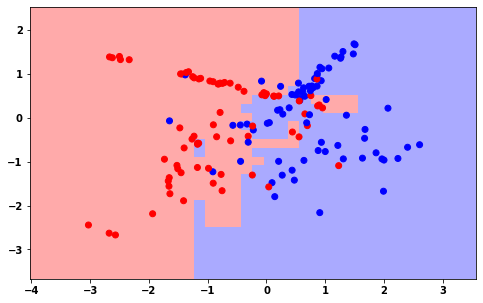

In [4]:
from catboost import CatBoostClassifier 

catboost = CatBoostClassifier(n_estimators=300, logging_level='Silent')
catboost.fit(X_train, y_train)
plot_surface(X_test, y_test, catboost)

print(roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1]))

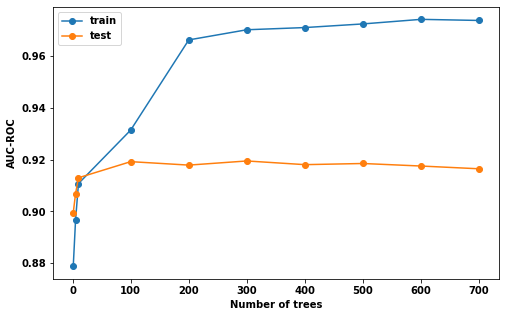

In [5]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    catboost = CatBoostClassifier(iterations=n, logging_level='Silent')
    catboost.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()
plt.show()

## Xgboost

1. Базовый алгоритм приближает направление, посчитанное с учетом второй производной функции потерь

2. Функционал регуляризуется – добавляются штрафы за количество листьев и за норму коэффициентов

3. При построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига

4. Критерий останова при обучении дерева также зависит от оптимального сдвига

Ссылка на [источник](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/lecture-notes/lecture11-ensembles.pdf)

0.8745554765291608


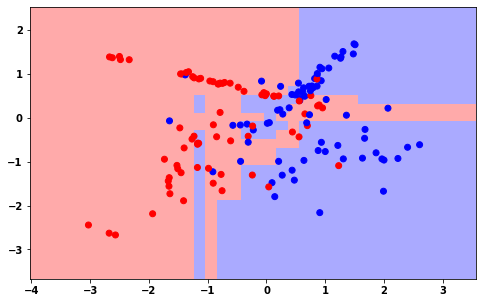

In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=300, verbosity=0)
xgb.fit(X_train, y_train)
plot_surface(X_test, y_test, xgb)

print(roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

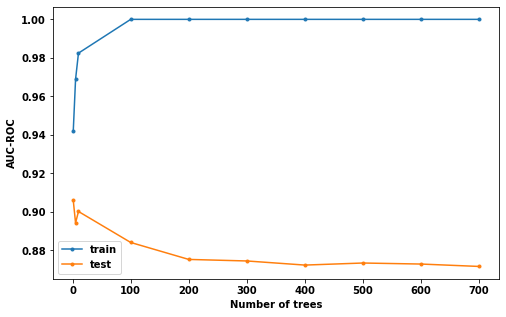

In [7]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    xgboost = XGBClassifier(n_estimators=n, verbosity=0)
    xgboost.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, xgboost.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, xgboost.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Видно, что переобучились - качество на тесте только падает.

## LightGBM

0.8733108108108107


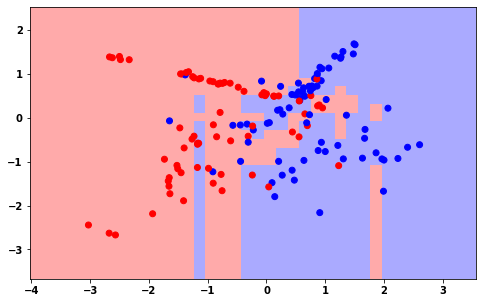

In [8]:
from lightgbm import LGBMClassifier

lightgbm = LGBMClassifier(n_estimators=300)
lightgbm.fit(X_train, y_train)
plot_surface(X_test, y_test, lightgbm)

print(roc_auc_score(y_test, lightgbm.predict_proba(X_test)[:, 1]))

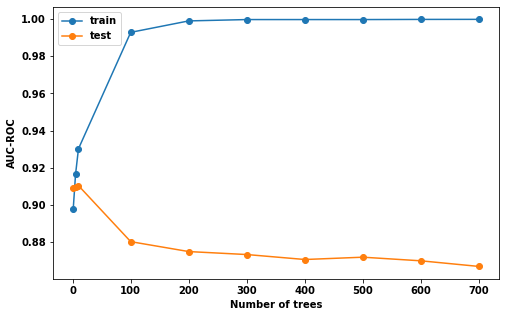

In [9]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    lightgbm = LGBMClassifier(n_estimators=n)
    lightgbm.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, lightgbm.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lightgbm.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='o', label='train')
plt.plot(n_trees, quals_test, marker='o', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

В целом, у LightGBM получилась та же проблема с переобучением, как у Xgboost. Нужно дальше подбирать гиперпараметры для этих двух.

Попробуем взять фиксированное количество деревьев `n_estimators`, но будем менять их максимальную глубину `max_depth`. У этих алгоритмов разное время обучения, поэтому возьмем какой-то небольшой диапазон глубины и сравним все три модели - Catboost, LightGBM, Xgboost.

In [10]:
def plot_model_diff_depths(model=LGBMClassifier, depth_range=list(range(1, 5)), n_trees=10):
    roc_auc_train = []
    roc_auc_test = []
    for i in depth_range:
        clf = model(n_estimators=n_trees, max_depth=i)
        if type(clf) == type(CatBoostClassifier()):
            clf = CatBoostClassifier(n_estimators=n_trees, max_depth=i, logging_level="Silent")
        clf.fit(X_train, y_train)
        q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
        q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        roc_auc_train.append(q_train)
        roc_auc_test.append(q_test)

    plt.figure(figsize=(7, 5))
    plt.plot(depth_range, roc_auc_train, marker='o', label='train')
    plt.plot(depth_range, roc_auc_test, marker='o', label='test')
    plt.title(f'{model}')
    plt.xlabel('Depth')
    plt.ylabel('AUC-ROC')
    plt.legend()

    plt.show()

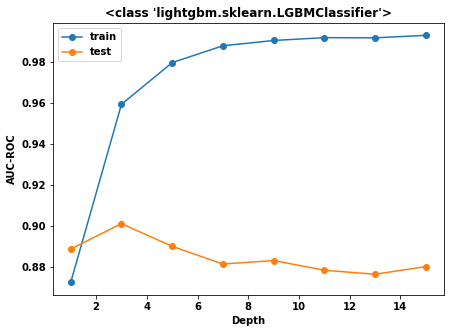

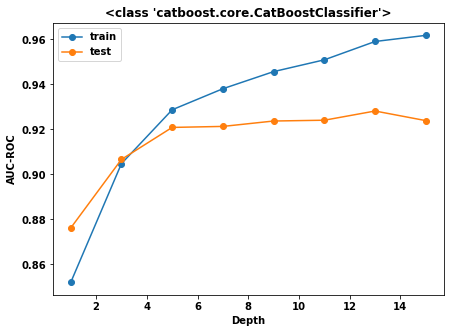

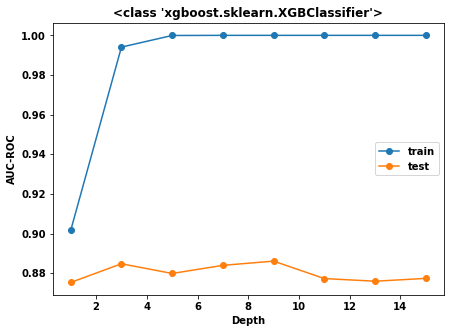

In [11]:
plot_model_diff_depths(model=LGBMClassifier, depth_range=list(range(1, 16, 2)), n_trees=100)
plot_model_diff_depths(model=CatBoostClassifier, depth_range=list(range(1, 16, 2)), n_trees=100)
plot_model_diff_depths(model=XGBClassifier, depth_range=list(range(1, 16, 2)), n_trees=100)

Когда мы обучили лучшие версии моделей, можно их сохранить и использовать для получения предсказаний, например, на новом батче данных. 

In [12]:
# Сохранить
lightgbm.booster_.save_model('lightgbm.txt')
catboost.save_model('catboost.cbm', format='cbm')
xgboost.save_model('xgboost.json')

# Загрузить
lightgbm = LGBMClassifier(model_file='mode.txt')
catboost = catboost.load_model('catboost.cbm')
xgboost = xgboost.load_model('xgboost.json')

### Блендинг

В этом подходе предсказания строятся как взвешенная сумма базовых алгоритмов. 

Рассмотрим простой пример блендинга градиентного бустинга и линейной регрессии для датасете `load_boston` и оценкой качества через RMSE.

Поделим выборку на обучающую (60%), тестовую (20%) и валидационную (20%). 

In [13]:
from sklearn.datasets import load_boston

data = load_boston()
X_init = pd.DataFrame(data.data, columns=data.feature_names)
y_init = data.target

X, X_test, y, y_test = train_test_split(X_init, y_init, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

assert X_init.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

Посмотрим, какое у нас качество у алгоритмов, если просто обучим на train и проверим качество на test:

In [14]:
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
cbm.fit(X_train, y_train)
test_pred_cbm = cbm.predict(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
test_pred_lr = lr.predict(X_test)

print("Test RMSE Linear Regression = %.3f" % rmse(y_test, test_pred_lr))
print("Test RMSE Catboost = %.3f" % rmse(y_test, test_pred_cbm))

Test RMSE Linear Regression = 5.030
Test RMSE Catboost = 5.706


Представим новый алгоритм $a(x)$ как взвешенную сумму из базовых алгоритмов:
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
где $\sum_{n} w_n =1$ и нам нужно подобрать $w_n$. 

Сначала рассмотрим более простой случай, когда пробуем подбирать, с какими весами нам взять предсказания алгоритмов методом перебора пар весов (т.к. у нас только два алгоритма). 

Будем веса подбирать на валидации, а проверять качество на тесте.

In [15]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
    return metric

In [16]:
val_pred_cbm = cbm.predict(X_val)
val_pred_lr = lr.predict(X_val)

rmse_blending_train, w_0, w_1 = min(select_weights(y_val, val_pred_cbm, val_pred_lr), key=lambda x: x[0])
rmse_blending_train, w_0, w_1 

(4.572981570798132, 0.2552552552552553, 0.7447447447447447)

In [17]:
round(rmse(y_test, test_pred_cbm * w_0 +  test_pred_lr * w_1), 3)

4.631

В данном случае видно, что нам с помощью блендинга с весами примерно 26% из градиентного бустинга и 74% из линейной регрессии удалось снизить ошибку на тесте до 4.63. 

Давайте теперь напишем классическую версию блендинга, который выполняется по следующей схеме. Возьмем обучающую и тестовую выборку и разделим обучающую выборку на две части. На первой части обучим базовые алгоритмы, на второй - обучим мета-алгоритм из предсказаний базовых алгоритмов, и потом получим предсказания тестовых мета-признаках. 
<img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking.png?w=1400' width=600>

Посмотрим на все шаги с самого начала, c момента загрузки исходных данных:

In [18]:
data = load_boston()
X_init = pd.DataFrame(data.data, columns=data.feature_names)
y_init = data.target

X, X_test, y, y_test = train_test_split(X_init, y_init, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

assert X_init.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

In [19]:
from lightgbm import LGBMRegressor

gb = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
gb.fit(X_train, y_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

meta_train_df = pd.DataFrame()
meta_train_df['gb_preds'] = gb.predict(X_val)
meta_train_df['lr_preds'] = lr.predict(X_val)

meta_algo = LGBMRegressor()
meta_algo.fit(meta_train_df, y_val)

meta_pred_df = pd.DataFrame()
meta_pred_df['gb_preds'] = gb.predict(X_test)
meta_pred_df['lr_preds'] = lr.predict(X_test)
test_preds_meta = meta_algo.predict(meta_pred_df)

rmse(y_test, test_preds_meta)

4.848084651946907

Получается, что при блендинге базовые алгоритмы и мета-алгоритм не используют весь объем выборки обучения, что является недостатком. Для повышения качества нужно усреднять несколько блендигов.

### Стэкинг

Попробуем реализовать стэкинг. Выборку разбивают на два фолда, последовательно перебирая фолды, обучают базовые алгоритмы на всех фолдах, кроме одного, а на оставшемся получают ответы базовых алгоритмов и используют их как значения соответствующих признаков на этом фолде. Для получения мета-признаков объектов тестовой выборки базовые алгоритмы обучают на всей обучающей выборке и берут их ответы на тестовой.

<img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking-2b.png?w=1400' width=600>

Для стэкинга можно пользоваться встроенной имплементацией в sklearn. Возьмем случайный лес и линейную регрессию как базовые алгоритмы, и потом обучим поверх с помощью 10-фолдовой кросс-валидации мета-алгоритм - градиентный бустинг.

In [20]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

estimators = [('rf', RandomForestRegressor(n_estimators=200,random_state=42)),
              ('lr', LinearRegression())]

reg = StackingRegressor(estimators=estimators,
                        cv=10,
                        final_estimator=CatBoostRegressor(iterations=700, max_depth=5, learning_rate=0.01, 
                                       loss_function='RMSE', logging_level='Silent'))

reg.fit(X_train, y_train).score(X_test, y_test)
reg_preds = reg.predict(X_test)
round(rmse(y_test, reg_preds), 3)

3.787

Кстати, довольно полезно, что после обучения градиентного бустинга можно посмотреть на то, какие из признаков оказались наиболее важные и значимые (feature importances). Рассмотрим на примере Catboost:

In [21]:
gb = CatBoostRegressor(n_estimators=100, logging_level="Silent")
gb.fit(X_train, y_train)

for val, name in sorted(zip(gb.feature_importances_, data.feature_names))[::-1]:
    print(name, val)

RM 31.204692893394494
LSTAT 26.259687954177885
PTRATIO 8.13854730392827
DIS 6.500655348356541
CRIM 6.195533443030281
AGE 5.487369730241581
TAX 4.880169613772956
B 3.653165174068535
INDUS 2.2418746339221256
NOX 2.149940735620899
RAD 1.3437368053943175
CHAS 1.1379659635877812
ZN 0.8066604005043025


Важность признака &mdash; это то, насколько в среднем меняется ответ модели при изменении значения данного признака (изменении значения разбиения).

$$feature\_importance_{F} = \sum_{tree, leaves_F} (v_1 - avr)^2\cdot c_1 +(v_2 - avr)^2\cdot c_2\\
\qquad avr = \frac{v_1 \cdot c_1 + v_2 \cdot c_2}{c_1 + c_2}.$$

Запись $leaves_F$ означает разбиение, зависящее от признака $F$.

Мы сравниваем поддеревья, отличающиеся значением сплита в узле на пути к ним: если условие сплита выполняется, объект попадает в левое поддерево, иначе &mdash; в правое. $c_1, c_2 - $  число объектов обучающего датасета, попавших в левое и правое поддерево соотвественно, либо суммарный вес этих объектов, если используются веса; $v1, v2 -$значение модели в левом и правом поддереве.
Значения $feature\_importance$ нормируются и суммируются в 100.

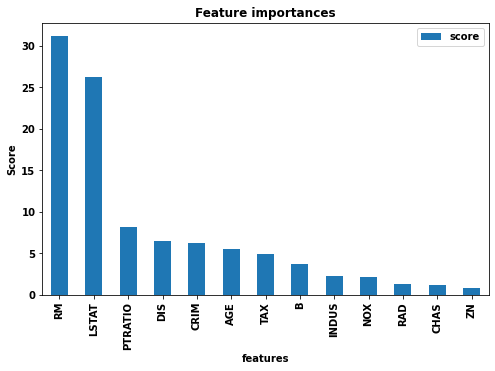

In [22]:
df = pd.DataFrame.from_dict(dict(zip(data.feature_names, gb.feature_importances_)), 
                       orient='index').reset_index()
df.columns = ['features', 'score']
df.sort_values(by='score', ascending=False, inplace=True)
df.plot(x='features', y='score', kind='bar', title='Feature importances')
plt.ylabel('Score');

Так же, для измерения важности признаков используются вектора Шепли. Имплементация доступна в [библиотеке SHAP](https://github.com/slundberg/shap). Будем зашумлять входные данные по каждой переменной, чтобы понять, важная она или нет. 

In [25]:
!pip3 install shap==0.31.0

"pip3" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


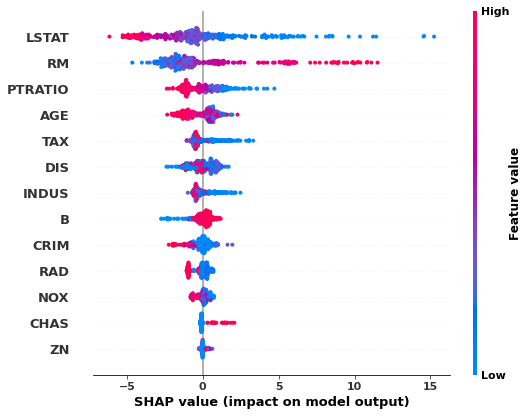

In [26]:
from catboost import Pool
import shap

shap_values = gb.get_feature_importance(Pool(X), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X)

In [27]:
print(f'Диапазон значений целевой переменной ({y.min()}, {y.max()})')

Диапазон значений целевой переменной (5.0, 50.0)


Как его читать:

- Значения по оси X - отрицательное или положительное влияние на целевую переменную при изменении признаков. 
- Чем краснее точки на графике, тем выше значения фичи в ней
- Чем толще линия на графике, тем больше таких точек наблюдения